<a href="https://colab.research.google.com/github/Sumanjali23/Adversarial-camouflage-in-Autonomous-Vehicles/blob/main/YOLOv8_Stage3_Adversarial_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📓 YOLOv8 — Rebuild + Adversarial Training (Stage-3)

This notebook **recreates the pipeline** and adds **adversarial training (AT)** with a minimal, reproducible setup.

**It does:**
- Install Ultralytics and mount Google Drive.  
- *(Optional)* Stage-1 training on cropped speed-limit signs.  
- Stage-2 fine-tune on driver-POV images (single class = `speedlimits`).  
- Generate **PGD** adversarial copies for a subset of train images (**bbox-masked** to the sign area).  
- Stage-3 **Adversarial Training** on **clean ∪ adversarial** images.  
- *(Optional)* **JPEG-aware** fine-tune (q≈70–85) and **low-Q top-up** (q∈{60,50,40}) to handle harsh compression.  
- Quick evaluation on your unlabeled test folder (confidence summary) + attacked & defended versions (**JPEG / bilateral**).

**Quick start**
1. Place in **My Drive/CAPSTONE**: `Data_stage2.zip`, `test.zip` (and `Data_stage1.zip` if using Stage-1), plus prior runs in `runs_speedlimits/`.  
2. Run the notebook top-to-bottom. It **auto-finds the newest `best.pt`** under `runs_speedlimits/**/weights/` for Stage-2.  
3. Adjust AT knobs in the config cell:  
   `FRACTION_ADV` (0.3–0.5), `EPS=8/255`, `STEPS=10`, `PAD_PX=12`, training epochs/LR.

**Outputs**
- New weights under `runs_speedlimits/stage3_*/weights/best.pt`.  
- CSV summaries in `eval_at_only/summaries/` (clean, PGD, PGD+JPEG, PGD+bilateral, ε-sweep, etc.).

**Notes**
- This is **offline AT** (craft once, then fine-tune) — fast and effective for this project.  
- Tested environment: Ultralytics ≥ **8.3.x**, NumPy **2.0.2**, Torch **2.6.0+cu124** (Colab T4).


##  Setup & Drive mount


In [1]:
#  setup
from google.colab import drive


try:
    drive.flush_and_unmount()
except ValueError:
    pass

drive.mount('/content/drive', force_remount=True)

# Install versions that are compatible with NumPy 2 and Colab's Torch
%pip -q install --no-cache-dir -U "numpy==2.0.2" "ultralytics>=8.3.0" opencv-python-headless==4.10.0.84 matplotlib==3.8.4

# Imports
import numpy as np, torch, cv2
from ultralytics import YOLO
import os, glob, shutil, zipfile, math, csv

print("NumPy:", np.__version__)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("OpenCV:", cv2.__version__)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 239.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
NumPy: 2.0.2
Torch: 2.8.0+cu126
CUDA available: False
OpenCV: 4.10.0


In [ ]:
# paths & unzip (idempotent)
import os, glob, shutil, zipfile

DRIVE_ROOT = "/content/drive/MyDrive/CAPSTONE"

DATA_STAGE1_ZIP = f"{DRIVE_ROOT}/Data_stage1.zip"
DATA_STAGE2_ZIP = f"{DRIVE_ROOT}/Data_stage2.zip"
TEST_ZIP        = f"{DRIVE_ROOT}/test.zip"

DATA_STAGE1 = f"{DRIVE_ROOT}/data_stage1"
DATA_STAGE2 = f"{DRIVE_ROOT}/data_stage2"
TEST_IMAGES = f"{DRIVE_ROOT}/test_images"
PROJECT     = f"{DRIVE_ROOT}/runs_speedlimits"

for d in [DATA_STAGE1, DATA_STAGE2, TEST_IMAGES, PROJECT]:
    os.makedirs(d, exist_ok=True)

def unzip_into(zip_path, out_dir):
    if not os.path.exists(zip_path):
        print("Zip not found (skip):", zip_path); return
    if any(os.scandir(out_dir)):
        print("Skip unzip (already populated):", out_dir); return
    print("Unzipping", zip_path, "→", out_dir)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)

    entries = [e for e in os.scandir(out_dir)]
    if len(entries) == 1 and entries[0].is_dir():
        inner = entries[0].path
        for e in os.scandir(inner):
            shutil.move(e.path, os.path.join(out_dir, os.path.basename(e.path)))
        shutil.rmtree(inner, ignore_errors=True)
    print("Done unzip:", out_dir)

unzip_into(DATA_STAGE1_ZIP, DATA_STAGE1)
unzip_into(DATA_STAGE2_ZIP, DATA_STAGE2)
unzip_into(TEST_ZIP,        TEST_IMAGES)

print("Stage2 data:", DATA_STAGE2)
print("Test images:", TEST_IMAGES)


Skip unzip (already populated): /content/drive/MyDrive/CAPSTONE/data_stage1
Skip unzip (already populated): /content/drive/MyDrive/CAPSTONE/data_stage2
Skip unzip (already populated): /content/drive/MyDrive/CAPSTONE/test_images
Stage2 data: /content/drive/MyDrive/CAPSTONE/data_stage2
Test images: /content/drive/MyDrive/CAPSTONE/test_images


In [ ]:
# find newest Stage-2 best.pt under runs_speedlimits/**/weights/
import glob, os

cands = glob.glob(f"{PROJECT}/**/weights/best.pt", recursive=True)
if not cands:
    raise FileNotFoundError(
        "No best.pt found under CAPSTONE/runs_speedlimits/**/weights/.\n"
        "If you know it, set STAGE2_WEIGHTS manually below and re-run."
    )

STAGE2_WEIGHTS = max(cands, key=os.path.getmtime)
print("Using Stage-2 weights:", STAGE2_WEIGHTS)


Using Stage-2 weights: /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage2_adv_ft_eps4_subset2/weights/best.pt


In [ ]:
#  Adversarial Training hyperparameters

# image sizes
IMGSZ_TRAIN  = 640
IMGSZ_INFER  = 896

# PGD attack settings (used to create adversarial TRAIN copies)
FRACTION_ADV = 0.5
EPS          = 8/255
ALPHA        = 2/255
STEPS        = 10
PAD_PX       = 12
RAND_START   = True

# Stage-3 fine-tune settings
EPOCHS_S3    = 15
BATCH_S3     = 8
LR0_S3       = 0.0015


In [ ]:
#  helpers (letterbox, mask, read YOLO labels)
import math, os, cv2, numpy as np

def letterbox(im, new_shape=IMGSZ_TRAIN, color=(114,114,114)):
    h, w = im.shape[:2]
    r = min(new_shape / h, new_shape / w)
    nh, nw = int(round(h * r)), int(round(w * r))
    im_resized = cv2.resize(im, (nw, nh), interpolation=cv2.INTER_LINEAR)
    top = (new_shape - nh) // 2
    bottom = new_shape - nh - top
    left = (new_shape - nw) // 2
    right = new_shape - nw - left
    im_padded = cv2.copyMakeBorder(im_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im_padded, r, (left, top), (nh, nw)

def mask_from_xyxy(x1,y1,x2,y2, H, W, pad=0):
    x1 = max(0, int(math.floor(x1 - pad)))
    y1 = max(0, int(math.floor(y1 - pad)))
    x2 = min(W, int(math.ceil (x2 + pad)))
    y2 = min(H, int(math.ceil (y2 + pad)))
    m = np.zeros((H,W,1), np.float32)
    m[y1:y2, x1:x2, 0] = 1.0
    return m

def read_yolo_labels(lbl_path, W, H):
    """YOLO .txt: class cx cy w h (normalized) → list of [x1,y1,x2,y2] in pixels."""
    boxes = []
    if not os.path.exists(lbl_path):
        return boxes
    with open(lbl_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            _, cx, cy, w, h = map(float, parts[:5])
            cx *= W; cy *= H; w *= W; h *= H
            x1 = cx - w/2; y1 = cy - h/2; x2 = cx + w/2; y2 = cy + h/2
            boxes.append([x1,y1,x2,y2])
    return boxes


In [ ]:
#  build mixed train set (clean ∪ adversarial PGD copies)

import os, glob, shutil, cv2, torch, numpy as np
from ultralytics import YOLO

# Stage-2 train folders
STAGE2_TRAIN_IMG = f"{DATA_STAGE2}/train/images"
STAGE2_TRAIN_LBL = f"{DATA_STAGE2}/train/labels"

# Output mixed dataset (clean + adversarial copies)
DATA_STAGE2_ADV_IMG = f"{DRIVE_ROOT}/data_stage2_adv/train/images"
DATA_STAGE2_ADV_LBL = f"{DRIVE_ROOT}/data_stage2_adv/train/labels"
os.makedirs(DATA_STAGE2_ADV_IMG, exist_ok=True)
os.makedirs(DATA_STAGE2_ADV_LBL, exist_ok=True)

# 1) Copy all clean images and labels (safe to re-run; will overwrite)
for p in glob.glob(os.path.join(STAGE2_TRAIN_IMG, "*")):
    shutil.copy2(p, os.path.join(DATA_STAGE2_ADV_IMG, os.path.basename(p)))
for p in glob.glob(os.path.join(STAGE2_TRAIN_LBL, "*.txt")):
    shutil.copy2(p, os.path.join(DATA_STAGE2_ADV_LBL, os.path.basename(p)))

# 2) Pick subset to attack (~FRACTION_ADV)
all_imgs = sorted(glob.glob(os.path.join(STAGE2_TRAIN_IMG, "*")))
step = max(1, int(round(1.0 / max(1e-6, FRACTION_ADV))))
attack_imgs = all_imgs[::step]
print(f"Will create adversarial copies for ~{len(attack_imgs)} / {len(all_imgs)} train images")

# 3) Load raw model for gradients
raw_model = YOLO(STAGE2_WEIGHTS).model
if torch.cuda.is_available():
    raw_model = raw_model.cuda()
device = next(raw_model.parameters()).device
raw_model.eval()

def collect_tensors(x):
    import torch as _torch
    if _torch.is_tensor(x):
        return [x]
    out = []
    try:
        for it in x:
            out.extend(collect_tensors(it))
    except Exception:
        pass
    return out

made = 0
for i, img_path in enumerate(attack_imgs, 1):
    stem, ext = os.path.splitext(os.path.basename(img_path))
    lbl_path = os.path.join(STAGE2_TRAIN_LBL, stem + ".txt")

    im0_bgr = cv2.imread(img_path)
    if im0_bgr is None:
        continue
    im0_rgb = im0_bgr[:, :, ::-1]
    H0, W0 = im0_rgb.shape[:2]

    # read GT boxes; skip images without labels
    gt_boxes = read_yolo_labels(lbl_path, W0, H0)
    if not gt_boxes:
        continue

    # letterbox to square
    im_sq, r, (px,py), (nh,nw) = letterbox(im0_rgb, IMGSZ_TRAIN)
    H = W = IMGSZ_TRAIN

    # union mask over GT boxes with padding
    mask_sq = np.zeros((H, W, 1), np.float32)
    for (x1o,y1o,x2o,y2o) in gt_boxes:
        x1 = x1o * r + px; y1 = y1o * r + py
        x2 = x2o * r + px; y2 = y2o * r + py
        mask_sq = np.maximum(mask_sq, mask_from_xyxy(x1,y1,x2,y2, H, W, pad=PAD_PX))

    # tensors
    img_sq = im_sq.astype(np.float32) / 255.0
    img_t  = torch.from_numpy(img_sq).permute(2,0,1).unsqueeze(0).to(device)   # [1,3,H,W]
    mask_t = torch.from_numpy(mask_sq).permute(2,0,1).unsqueeze(0).to(device)  # [1,1,H,W]
    img_t  = img_t.clamp(0,1).detach()

    # init adversarial image
    if RAND_START:
        adv = (img_t + (torch.empty_like(img_t).uniform_(-EPS, EPS)) * mask_t).clamp(0,1).detach()
    else:
        adv = img_t.clone().detach()
    adv.requires_grad_(True)

    # PGD steps (descend on proxy = mean(obj*cls))
    for _ in range(STEPS):
        raw_model.zero_grad(set_to_none=True)
        adv.retain_grad()
        out = raw_model(adv, augment=False)[0]

        parts = collect_tensors(out)
        scalars = []
        for t in parts:
            if t.dim() == 5:        # [B, A, H, W, C]
                B,A,HH,WW,C = t.shape
                T = t.permute(0,2,3,1,4).reshape(B, HH*WW*A, C)
            elif t.dim() == 4:      # [B, C, H, W]
                B,C,HH,WW = t.shape
                T = t.permute(0,2,3,1).reshape(B, HH*WW, C)
            elif t.dim() == 3:
                T = t
            else:
                T = t.view(t.shape[0], -1, t.shape[-1])

            Cc = T.shape[-1]
            if Cc >= 5:
                obj = torch.sigmoid(T[..., 4])
                if Cc > 5:
                    cls = torch.sigmoid(T[..., 5:]).max(dim=-1).values
                else:
                    cls = torch.ones_like(obj)
                scalars.append((obj * cls).mean())

        if not scalars:
            break

        proxy = sum(scalars) / len(scalars)
        proxy.backward()
        grad_sign = adv.grad.sign()

        adv = (adv - ALPHA * grad_sign * mask_t).clamp(0,1).detach()
        # project back into L_inf ball around img_t
        delta = (adv - img_t).clamp(-EPS, EPS) * mask_t
        adv   = (img_t + delta).clamp(0,1).detach()
        adv.requires_grad_(True)

    # map perturbation back to original size and save
    adv_sq = adv.detach().cpu().numpy()[0].transpose(1,2,0)  # HWC RGB
    delta_sq  = adv_sq - img_sq
    delta_crop = delta_sq[py:py+nh, px:px+nw, :]
    delta_orig = cv2.resize(delta_crop, (W0, H0), interpolation=cv2.INTER_LINEAR)
    adv_orig = (im0_rgb.astype(np.float32)/255.0 + delta_orig).clip(0,1)
    adv_bgr  = (adv_orig[:, :, ::-1] * 255.0).astype(np.uint8)

    adv_name = f"{stem}_adv{ext}"
    cv2.imwrite(os.path.join(DATA_STAGE2_ADV_IMG, adv_name), adv_bgr)
    shutil.copy2(lbl_path, os.path.join(DATA_STAGE2_ADV_LBL, f"{stem}_adv.txt"))

    made += 1
    if i % 50 == 0:
        print(f"Created {made}/{len(attack_imgs)} adversarial copies")

print("Adversarial copies created:", made)


Will create adversarial copies for ~104 / 207 train images
Created 50/104 adversarial copies
Created 100/104 adversarial copies
Adversarial copies created: 104


In [ ]:
#  Stage-3 YAML
STAGE3_YAML = "/content/speedlimits_stage3.yaml"
with open(STAGE3_YAML, "w") as f:
    f.write(
        f"train: {DRIVE_ROOT}/data_stage2_adv/train/images\n"
        f"val:   {DATA_STAGE2}/valid/images\n"
        f"nc: 1\n"
        f"names: [speedlimits]\n"
    )
print(open(STAGE3_YAML).read())


train: /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/images
val:   /content/drive/MyDrive/CAPSTONE/data_stage2/valid/images
nc: 1
names: [speedlimits]



In [ ]:
#  Stage-3 adversarial fine-tune
from ultralytics import YOLO
import torch

print("Running Stage-3 adversarial fine-tune...")
model = YOLO(STAGE2_WEIGHTS)

r = model.train(
    data=STAGE3_YAML,
    epochs=EPOCHS_S3,        # e.g., 15
    imgsz=IMGSZ_TRAIN,       # 640
    batch=BATCH_S3,          # e.g., 8 (lower to 4 if OOM)
    lr0=LR0_S3,              # 0.0015
    cos_lr=True,
    weight_decay=0.0005,
    patience=5,
    device=0 if torch.cuda.is_available() else None,
    project=PROJECT,
    name="stage3_advtrain",
)

STAGE3_WEIGHTS = f"{PROJECT}/stage3_advtrain/weights/best.pt"
print("Stage-3 best weights:", STAGE3_WEIGHTS)


Running Stage-3 adversarial fine-tune...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/speedlimits_stage3.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage2_adv_ft_eps4_subset2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=stage3_advtrain, nbs=64, nms=F


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.1 ms, read: 16.3±3.2 MB/s, size: 36.4 KB)


train: Scanning /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/labels... 311 images, 0 backgrounds, 0 corrupt: 100%|██████████| 311/311 [00:02<00:00, 113.41it/s]


train: New cache created: /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.1±0.0 MB/s, size: 37.0 KB)


val: Scanning /content/drive/MyDrive/CAPSTONE/data_stage2/valid/labels... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:32<00:00,  1.61it/s]

val: New cache created: /content/drive/MyDrive/CAPSTONE/data_stage2/valid/labels.cache


Plotting labels to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.16G     0.6807     0.4545     0.8786          8        640: 100%|██████████| 39/39 [00:09<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all         52         52      0.998          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.41G     0.7241     0.5127     0.8881         13        640: 100%|██████████| 39/39 [00:06<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.59it/s]

                   all         52         52      0.999          1      0.995      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.42G     0.7552     0.5136     0.8861         11        640: 100%|██████████| 39/39 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]

                   all         52         52      0.997          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.44G     0.7451     0.5153     0.9037          8        640: 100%|██████████| 39/39 [00:07<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all         52         52          1          1      0.995      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.46G     0.7436     0.5139     0.8948         10        640: 100%|██████████| 39/39 [00:06<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.46it/s]

                   all         52         52      0.996          1      0.995      0.865


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.47G     0.6709     0.4841     0.8918          8        640: 100%|██████████| 39/39 [00:08<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all         52         52      0.978          1      0.994       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.49G     0.6422     0.4523       0.87          7        640: 100%|██████████| 39/39 [00:06<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

                   all         52         52      0.997          1      0.995      0.873


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

7 epochs completed in 0.017 hours.
Optimizer stripped from /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all         52         52      0.999          1      0.995      0.875
Speed: 0.4ms preprocess, 6.0ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain
Stage-3 best weights: /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/weights/best.pt


In [ ]:
# eval helpers
import cv2, numpy as np, torch
from ultralytics import YOLO

def jpeg_compress(img_bgr, quality=75):
    ok, enc = cv2.imencode(".jpg", img_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)])
    if not ok: return img_bgr
    return cv2.imdecode(enc, cv2.IMREAD_COLOR)

def bilateral(img_bgr, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img_bgr, d, sigmaColor, sigmaSpace)

def predict_conf(weights, img_path, imgsz=896, conf=0.25, iou=0.5):
    m = YOLO(weights)
    r = m.predict(source=img_path, imgsz=imgsz, conf=conf, iou=iou, verbose=False)
    if not r: return None
    boxes = r[0].boxes
    if boxes is None or boxes.conf is None or len(boxes.conf)==0:
        return None
    return float(boxes.conf.max().item())

def pgd_attack_predbox(img_bgr, weights, imgsz_train=640, eps=8/255, alpha=2/255, steps=10, pad_px=12):
    # Attack around predicted bbox (since test has no labels)
    raw = YOLO(weights).model.eval()
    device = next(raw.parameters()).device
    im0_rgb = img_bgr[:,:,::-1]
    H0,W0 = im0_rgb.shape[:2]

    pred = YOLO(weights)(im0_rgb, imgsz=imgsz_train, conf=0.1, verbose=False)[0]
    if pred.boxes is not None and len(pred.boxes.xyxy)>0:
        x1,y1,x2,y2 = pred.boxes.xyxy[0].detach().cpu().numpy().tolist()
    else:
        x1,y1,x2,y2 = 0,0,W0,H0

    # letterbox
    def _letterbox(im, new_shape=imgsz_train, color=(114,114,114)):
        h, w = im.shape[:2]
        r = min(new_shape / h, new_shape / w)
        nh, nw = int(round(h * r)), int(round(w * r))
        im_resized = cv2.resize(im, (nw, nh), interpolation=cv2.INTER_LINEAR)
        top = (new_shape - nh) // 2
        bottom = new_shape - nh - top
        left = (new_shape - nw) // 2
        right = new_shape - nw - left
        im_padded = cv2.copyMakeBorder(im_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        return im_padded, r, (left, top), (nh, nw)

    def _mask_from_xyxy(x1,y1,x2,y2, H, W, pad=0):
        x1 = max(0, int(np.floor(x1 - pad)))
        y1 = max(0, int(np.floor(y1 - pad)))
        x2 = min(W, int(np.ceil (x2 + pad)))
        y2 = min(H, int(np.ceil (y2 + pad)))
        m = np.zeros((H,W,1), np.float32)
        m[y1:y2, x1:x2, 0] = 1.0
        return m

    im_sq, r, (px,py), (nh,nw) = _letterbox(im0_rgb, imgsz_train)
    H=W=imgsz_train
    x1l = x1*r+px; y1l=y1*r+py; x2l=x2*r+px; y2l=y2*r+py
    mask_sq = _mask_from_xyxy(x1l,y1l,x2l,y2l,H,W,pad=pad_px)

    img_sq = im_sq.astype(np.float32)/255.0
    img_t  = torch.from_numpy(img_sq).permute(2,0,1).unsqueeze(0).to(device)
    mask_t = torch.from_numpy(mask_sq).permute(2,0,1).unsqueeze(0).to(device)
    img_t  = img_t.clamp(0,1).detach()

    adv = (img_t + (torch.empty_like(img_t).uniform_(-eps,eps))*mask_t).clamp(0,1).detach()
    adv.requires_grad_(True)

    for _ in range(steps):
        raw.zero_grad(set_to_none=True)
        adv.retain_grad()
        out = raw(adv, augment=False)[0]

        # collapse to scalar proxy
        def collect(x):
            if torch.is_tensor(x): return [x]
            out2=[];
            try:
                for it in x: out2.extend(collect(it))
            except Exception:
                pass
            return out2
        parts = collect(out)
        scalars=[]
        for t in parts:
            if t.dim()==5:
                B,A,HH,WW,C=t.shape; T=t.permute(0,2,3,1,4).view(B,HH*WW*A,C)
            elif t.dim()==4:
                B,C,HH,WW=t.shape; T=t.permute(0,2,3,1).view(B,HH*WW,C)
            elif t.dim()==3:
                T=t
            else:
                T=t.view(t.shape[0], -1, t.shape[-1])
            Cc=T.shape[-1]
            if Cc>=5:
                obj=torch.sigmoid(T[...,4])
                cls=torch.sigmoid(T[...,5:]).max(dim=-1).values if Cc>5 else torch.ones_like(obj)
                scalars.append((obj*cls).mean())
        if not scalars: break
        proxy=(sum(scalars)/len(scalars))
        proxy.backward()
        grad_sign = adv.grad.sign()
        adv = (adv - (alpha*grad_sign)*mask_t).clamp(0,1).detach()
        delta = (adv - img_t).clamp(-eps, eps)*mask_t
        adv = (img_t + delta).clamp(0,1).detach()
        adv.requires_grad_(True)

    adv_sq = adv.detach().cpu().numpy()[0].transpose(1,2,0)
    delta_sq = adv_sq - img_sq
    delta_crop = delta_sq[py:py+nh, px:px+nw, :]
    delta_orig = cv2.resize(delta_crop, (W0, H0), interpolation=cv2.INTER_LINEAR)
    adv_orig = (im0_rgb.astype(np.float32)/255.0 + delta_orig).clip(0,1)
    adv_bgr  = (adv_orig[:,:,::-1]*255.0).astype(np.uint8)
    return adv_bgr


In [ ]:
#  prepare eval images
import os, glob, shutil, cv2

EVAL_DIR = f"{DRIVE_ROOT}/eval_at_only"
os.makedirs(EVAL_DIR, exist_ok=True)

clean_dir = os.path.join(EVAL_DIR, "clean")
pgd_dir   = os.path.join(EVAL_DIR, "pgd")
jpeg_dir  = os.path.join(EVAL_DIR, "pgd_jpeg")
bil_dir   = os.path.join(EVAL_DIR, "pgd_bilateral")
for d in [clean_dir, pgd_dir, jpeg_dir, bil_dir]:
    os.makedirs(d, exist_ok=True)

# copy clean test images
for p in glob.glob(os.path.join(TEST_IMAGES, "*")):
    if os.path.isdir(p): continue
    shutil.copy2(p, os.path.join(clean_dir, os.path.basename(p)))

# craft PGD using STAGE2_WEIGHTS (stronger test), then defenses
for p in sorted(glob.glob(os.path.join(clean_dir, "*"))):
    img = cv2.imread(p)
    if img is None: continue
    adv = pgd_attack_predbox(img, STAGE2_WEIGHTS, imgsz_train=IMGSZ_TRAIN, eps=EPS, alpha=ALPHA, steps=STEPS, pad_px=PAD_PX)
    base = os.path.basename(p)
    cv2.imwrite(os.path.join(pgd_dir, base), adv)
    cv2.imwrite(os.path.join(jpeg_dir, base), jpeg_compress(adv, quality=75))
    cv2.imwrite(os.path.join(bil_dir,  base), bilateral(adv))
print("Eval images prepared:", clean_dir, pgd_dir, jpeg_dir, bil_dir)


Eval images prepared: /content/drive/MyDrive/CAPSTONE/eval_at_only/clean /content/drive/MyDrive/CAPSTONE/eval_at_only/pgd /content/drive/MyDrive/CAPSTONE/eval_at_only/pgd_jpeg /content/drive/MyDrive/CAPSTONE/eval_at_only/pgd_bilateral


In [ ]:
#  summarize confidences and simple detection rates
import os, glob, csv
from ultralytics import YOLO

def summarize(dir_path, weights, tag, out_csv):
    rows = [["image","model","score"]]
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    m = YOLO(weights)
    det_count = 0
    scores = []
    for p in ims:
        r = m.predict(source=p, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        score = None
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            score = float(r[0].boxes.conf.max().item())
            det_count += 1
            scores.append(score)
        rows.append([os.path.basename(p), tag, score])
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        csv.writer(f).writerows(rows)
    avg = float(np.mean(scores)) if scores else None
    total = len([p for p in ims if not os.path.isdir(p)])
    print(f"{tag} on {os.path.basename(dir_path)} — det_rate={det_count}/{total}, avg_conf={avg}")
    return det_count, total, avg

summ_dir = os.path.join(EVAL_DIR, "summaries")
os.makedirs(summ_dir, exist_ok=True)

print("== CLEAN ==")
summarize(clean_dir, STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "clean_stage2.csv"))
summarize(clean_dir, STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "clean_stage3.csv"))

print("\n== PGD ==")
summarize(pgd_dir,  STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_stage2.csv"))
summarize(pgd_dir,  STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_stage3.csv"))

print("\n== PGD + JPEG ==")
summarize(jpeg_dir, STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_jpeg_stage2.csv"))
summarize(jpeg_dir, STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_jpeg_stage3.csv"))

print("\n== PGD + Bilateral ==")
summarize(bil_dir,  STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_bilateral_stage2.csv"))
summarize(bil_dir,  STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_bilateral_stage3.csv"))

print("\nCSV summaries saved to:", summ_dir)


== CLEAN ==
stage2 on clean — det_rate=20/20, avg_conf=0.8382613360881805
stage3 on clean — det_rate=20/20, avg_conf=0.8152572095394135

== PGD ==
stage2 on pgd — det_rate=19/20, avg_conf=0.7614401218138243
stage3 on pgd — det_rate=20/20, avg_conf=0.7433789223432541

== PGD + JPEG ==
stage2 on pgd_jpeg — det_rate=20/20, avg_conf=0.7371355816721916
stage3 on pgd_jpeg — det_rate=20/20, avg_conf=0.747087861597538

== PGD + Bilateral ==
stage2 on pgd_bilateral — det_rate=19/20, avg_conf=0.8012332979001497
stage3 on pgd_bilateral — det_rate=19/20, avg_conf=0.7664054255736502

CSV summaries saved to: /content/drive/MyDrive/CAPSTONE/eval_at_only/summaries


In [ ]:
#  craft PGD with Stage-3 weights and evaluate Stage-2 vs Stage-3
import os, glob, csv, cv2, numpy as np
from ultralytics import YOLO

pgd3_dir = os.path.join(EVAL_DIR, "pgd_from_stage3")
os.makedirs(pgd3_dir, exist_ok=True)

# Reuse pgd_attack_predbox from earlier but call with STAGE3_WEIGHTS
for p in sorted(glob.glob(os.path.join(clean_dir, "*"))):
    img = cv2.imread(p)
    if img is None: continue
    adv = pgd_attack_predbox(img, STAGE3_WEIGHTS, imgsz_train=IMGSZ_TRAIN, eps=EPS, alpha=ALPHA, steps=STEPS, pad_px=PAD_PX)
    cv2.imwrite(os.path.join(pgd3_dir, os.path.basename(p)), adv)

def summarize(dir_path, weights, tag, out_csv):
    rows = [["image","model","score"]]
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    m = YOLO(weights)
    det_count, scores = 0, []
    for p in ims:
        r = m.predict(source=p, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        score = None
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            score = float(r[0].boxes.conf.max().item())
            det_count += 1
            scores.append(score)
        rows.append([os.path.basename(p), tag, score])
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        csv.writer(f).writerows(rows)
    avg = float(np.mean(scores)) if scores else None
    total = len([p for p in ims if not os.path.isdir(p)])
    print(f"{tag} on pgd_from_stage3 — det_rate={det_count}/{total}, avg_conf={avg}")
    return det_count, total, avg

summ_dir = os.path.join(EVAL_DIR, "summaries")
os.makedirs(summ_dir, exist_ok=True)

print("== PGD crafted on STAGE-3 (white-box for Stage-3) ==")
summarize(pgd3_dir, STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_from_stage3_stage2.csv"))
summarize(pgd3_dir, STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_from_stage3_stage3.csv"))


== PGD crafted on STAGE-3 (white-box for Stage-3) ==
stage2 on pgd_from_stage3 — det_rate=20/20, avg_conf=0.7538540914654732
stage3 on pgd_from_stage3 — det_rate=19/20, avg_conf=0.7592366212292722


(19, 20, 0.7592366212292722)

In [ ]:
# epsilon sweep: craft with each model (white-box) at multiple eps, report avg conf
import csv, cv2, numpy as np, glob, os
from ultralytics import YOLO

EPS_LIST = [2/255, 4/255, 8/255, 12/255]
SWEEP_CSV = os.path.join(EVAL_DIR, "summaries", "eps_sweep_whitebox.csv")

def avg_conf_under_eps(weights, eps):
    ims = sorted(glob.glob(os.path.join(clean_dir, "*")))
    scores = []
    for p in ims:
        img = cv2.imread(p)
        if img is None: continue
        adv = pgd_attack_predbox(img, weights, imgsz_train=IMGSZ_TRAIN, eps=eps, alpha=max(eps/4, 1/255), steps=10, pad_px=PAD_PX)
        r = YOLO(weights).predict(source=adv, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            scores.append(float(r[0].boxes.conf.max().item()))
    return float(np.mean(scores)) if scores else None

rows = [["epsilon","model","avg_conf_whitebox"]]
for eps in EPS_LIST:
    for weights, tag in [(STAGE2_WEIGHTS,"stage2"), (STAGE3_WEIGHTS,"stage3")]:
        avgc = avg_conf_under_eps(weights, eps)
        rows.append([float(eps), tag, avgc])
        print(f"eps={eps:.5f} {tag}: avg_conf={avgc}")

os.makedirs(os.path.dirname(SWEEP_CSV), exist_ok=True)
with open(SWEEP_CSV, "w", newline="") as f:
    csv.writer(f).writerows(rows)

print("Saved sweep CSV to:", SWEEP_CSV)


eps=0.00784 stage2: avg_conf=0.8186317980289459
eps=0.00784 stage3: avg_conf=0.7917907297611236
eps=0.01569 stage2: avg_conf=0.7992060989141464
eps=0.01569 stage3: avg_conf=0.7681701138615609
eps=0.03137 stage2: avg_conf=0.7428529486060143
eps=0.03137 stage3: avg_conf=0.7662421935483029
eps=0.04706 stage2: avg_conf=0.7291736712581233
eps=0.04706 stage3: avg_conf=0.7471921899739433
Saved sweep CSV to: /content/drive/MyDrive/CAPSTONE/eval_at_only/summaries/eps_sweep_whitebox.csv


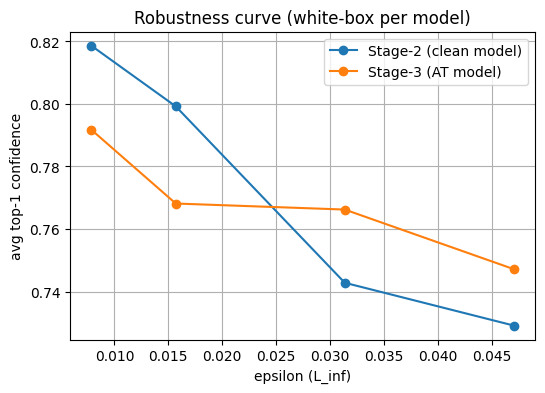

In [ ]:
# Plot Stage-2 vs Stage-3 average confidence vs epsilon (white-box per model)
import matplotlib.pyplot as plt

eps = [0.00784, 0.01569, 0.03137, 0.04706]  # 2/255, 4/255, 8/255, 12/255
stage2 = [0.8186317980289459, 0.7992060989141464, 0.7428529486060143, 0.7291736712581233]
stage3 = [0.7917907297611236, 0.7681701138615609, 0.7662421935483029, 0.7471921899739433]

plt.figure(figsize=(6,4))
plt.plot(eps, stage2, marker='o', label='Stage-2 (clean model)')
plt.plot(eps, stage3, marker='o', label='Stage-3 (AT model)')
plt.xlabel('epsilon (L_inf)')
plt.ylabel('avg top-1 confidence')
plt.title('Robustness curve (white-box per model)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# JPEG quality ablation
import csv, cv2, glob, os, numpy as np
from ultralytics import YOLO

QUALS = [95, 85, 75, 60, 50, 40]
ABLATE_CSV = os.path.join(EVAL_DIR, "summaries", "jpeg_ablation.csv")

def avg_conf_after_jpeg(dir_path, weights, q):
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    scores = []
    for p in ims:
        img = cv2.imread(p)
        if img is None: continue
        ok, enc = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), int(q)])
        comp = cv2.imdecode(enc, cv2.IMREAD_COLOR) if ok else img
        r = YOLO(weights).predict(source=comp, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            scores.append(float(r[0].boxes.conf.max().item()))
    return float(np.mean(scores)) if scores else None

rows = [["jpeg_quality","model","avg_conf_on_pgd"]]
for q in QUALS:
    for weights, tag in [(STAGE2_WEIGHTS,"stage2"), (STAGE3_WEIGHTS,"stage3")]:
        avgc = avg_conf_after_jpeg(pgd_dir, weights, q)
        rows.append([q, tag, avgc])
        print(f"JPEG q={q} {tag}: avg_conf={avgc}")

os.makedirs(os.path.dirname(ABLATE_CSV), exist_ok=True)
with open(ABLATE_CSV, "w", newline="") as f:
    csv.writer(f).writerows(rows)

print("Saved ablation CSV to:", ABLATE_CSV)


JPEG q=95 stage2: avg_conf=0.7620076646930293
JPEG q=95 stage3: avg_conf=0.7454981446266175
JPEG q=85 stage2: avg_conf=0.7456250861287117
JPEG q=85 stage3: avg_conf=0.7484832376241684
JPEG q=75 stage2: avg_conf=0.7410919338464736
JPEG q=75 stage3: avg_conf=0.7487228989601136
JPEG q=60 stage2: avg_conf=0.7654612472182826
JPEG q=60 stage3: avg_conf=0.7461052238941193
JPEG q=50 stage2: avg_conf=0.7662502715462133
JPEG q=50 stage3: avg_conf=0.7367408126592636
JPEG q=40 stage2: avg_conf=0.7889694634236788
JPEG q=40 stage3: avg_conf=0.7562580585479737
Saved ablation CSV to: /content/drive/MyDrive/CAPSTONE/eval_at_only/summaries/jpeg_ablation.csv


In [ ]:
# add JPEG-augmented copies to your AT train set, then quick 5-epoch fine-tune
import os, glob, cv2, random, shutil
from ultralytics import YOLO

SRC_IMG = f"{DRIVE_ROOT}/data_stage2_adv/train/images"   # mixed clean+adv you built
SRC_LBL = f"{DRIVE_ROOT}/data_stage2_adv/train/labels"
QUALS = [70, 75, 80, 85]
FRACTION = 0.3

imgs = sorted(glob.glob(os.path.join(SRC_IMG, "*")))
choices = imgs[::max(1, int(1/(FRACTION+1e-9)))]
print(f"JPEG-augmenting ~{len(choices)} / {len(imgs)} images")

def save_jpeg_copy(src_img_path, q):
    import os
    base = os.path.basename(src_img_path)
    stem, ext = os.path.splitext(base)
    dst_img = os.path.join(SRC_IMG, f"{stem}_jq{q}{ext}")
    im = cv2.imread(src_img_path)
    if im is None: return
    ok, enc = cv2.imencode(".jpg", im, [int(cv2.IMWRITE_JPEG_QUALITY), int(q)])
    if not ok: return
    comp = cv2.imdecode(enc, cv2.IMREAD_COLOR)
    cv2.imwrite(dst_img, comp)
    # duplicate the label
    lbl_src = os.path.join(SRC_LBL, stem + ".txt")
    if os.path.exists(lbl_src):
        shutil.copy2(lbl_src, os.path.join(SRC_LBL, f"{stem}_jq{q}.txt"))

for p in choices:
    q = random.choice(QUALS)
    save_jpeg_copy(p, q)

# quick fine-tune on the same YAML for a few epochs
print("Quick JPEG-aware fine-tune…")
model = YOLO(STAGE3_WEIGHTS)  # start from your AT weights
r = model.train(
    data=STAGE3_YAML,          # same mixed (now with _jq* files)
    epochs=5,                  # short top-up
    imgsz=IMGSZ_TRAIN,
    batch=max(4, BATCH_S3//2),
    lr0=LR0_S3 * 0.5,          # smaller LR
    cos_lr=True,
    weight_decay=0.0005,
    patience=3,
    device=0 if torch.cuda.is_available() else None,
    project=PROJECT,
    name="stage3_advtrain_jpegaware",
)
STAGE3J_WEIGHTS = f"{PROJECT}/stage3_advtrain_jpegaware/weights/best.pt"
print("JPEG-aware AT weights:", STAGE3J_WEIGHTS)


JPEG-augmenting ~104 / 311 images
Quick JPEG-aware fine-tune…
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/speedlimits_stage3.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00075, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=stage3_advtrain_jpeg

train: Scanning /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/labels... 415 images, 0 backgrounds, 0 corrupt: 100%|██████████| 415/415 [00:03<00:00, 125.83it/s]


train: New cache created: /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 13.7±8.9 MB/s, size: 36.2 KB)


val: Scanning /content/drive/MyDrive/CAPSTONE/data_stage2/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00075' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.15G     0.6992     0.4604      0.885          4        640: 100%|██████████| 104/104 [00:15<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.76it/s]

                   all         52         52      0.998          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.28G     0.7066     0.4896     0.8918          2        640: 100%|██████████| 104/104 [00:15<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.18it/s]

                   all         52         52      0.999          1      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.28G     0.6932     0.4918     0.8918          3        640: 100%|██████████| 104/104 [00:14<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.28it/s]

                   all         52         52      0.997          1      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.28G     0.6618      0.457     0.9025          5        640: 100%|██████████| 104/104 [00:14<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]

                   all         52         52      0.998          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.28G     0.6355     0.4229     0.8547          3        640: 100%|██████████| 104/104 [00:14<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]

                   all         52         52      0.998          1      0.995      0.891



5 epochs completed in 0.022 hours.
Optimizer stripped from /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


                   all         52         52      0.998          1      0.995      0.905
Speed: 0.4ms preprocess, 10.4ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware
JPEG-aware AT weights: /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware/weights/best.pt


In [ ]:
# Compare Stage-2 vs NEW Stage-3 at harsh JPEG qualities 60/50/40 on PGD images
import cv2, glob, os, numpy as np
from ultralytics import YOLO

def avg_conf_after_jpeg(dir_path, weights, q):
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    scores = []
    m = YOLO(weights)
    for p in ims:
        img = cv2.imread(p);
        if img is None: continue
        ok, enc = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), int(q)])
        comp = cv2.imdecode(enc, cv2.IMREAD_COLOR) if ok else img
        r = m.predict(source=comp, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            scores.append(float(r[0].boxes.conf.max().item()))
    return float(np.mean(scores)) if scores else None

for q in [60, 50, 40]:
    s2 = avg_conf_after_jpeg(pgd_dir, STAGE2_WEIGHTS, q)
    s3 = avg_conf_after_jpeg(pgd_dir, STAGE3_WEIGHTS, q)
    print(f"JPEG q={q}: stage2={s2}, stage3={s3}")


JPEG q=60: stage2=0.7654612472182826, stage3=0.7461052238941193
JPEG q=50: stage2=0.7662502715462133, stage3=0.7367408126592636
JPEG q=40: stage2=0.7889694634236788, stage3=0.7562580585479737


In [ ]:

import os, glob, cv2, random, shutil
from ultralytics import YOLO
import torch


SRC_IMG = f"{DRIVE_ROOT}/data_stage2_adv/train/images"
SRC_LBL = f"{DRIVE_ROOT}/data_stage2_adv/train/labels"

LOW_Q = [60, 50, 40]
FRACTION = 0.15   # keep small to avoid distribution drift

imgs = sorted(glob.glob(os.path.join(SRC_IMG, "*")))
choices = imgs[::max(1, int(1/(FRACTION+1e-9)))]
print(f"Adding low-q JPEG to ~{len(choices)} / {len(imgs)} images")

def write_lowq_copy(src_img_path, q):
    base = os.path.basename(src_img_path)
    stem, ext = os.path.splitext(base)
    dst_img = os.path.join(SRC_IMG, f"{stem}_jq{q}{ext}")
    im = cv2.imread(src_img_path)
    if im is None: return
    ok, enc = cv2.imencode(".jpg", im, [int(cv2.IMWRITE_JPEG_QUALITY), int(q)])
    comp = cv2.imdecode(enc, cv2.IMREAD_COLOR) if ok else im
    cv2.imwrite(dst_img, comp)
    # duplicate label
    lbl_src = os.path.join(SRC_LBL, stem + ".txt")
    if os.path.exists(lbl_src):
        shutil.copy2(lbl_src, os.path.join(SRC_LBL, f"{stem}_jq{q}.txt"))

for p in choices:
    q = random.choice(LOW_Q)
    write_lowq_copy(p, q)

# Fine-tune briefly from your JPEG-aware AT weights
print("Low-JPEG-aware top-up fine-tune…")

model = YOLO(STAGE3_WEIGHTS)

r = model.train(
    data=STAGE3_YAML,          # same YAML pointing to data_stage2_adv/train
    epochs=4,                  # 3–5 is enough
    imgsz=IMGSZ_TRAIN,
    batch=max(4, BATCH_S3//2),
    lr0=LR0_S3 * 0.5,          # smaller LR for gentle adaptation
    cos_lr=True,
    weight_decay=0.0005,
    patience=3,
    device=0 if torch.cuda.is_available() else None,
    project=PROJECT,
    name="stage3_advtrain_jpegaware_lowQ",
)
STAGE3_LOWQ_WEIGHTS = f"{PROJECT}/stage3_advtrain_jpegaware_lowQ/weights/best.pt"
print("Low-Q JPEG-aware AT weights:", STAGE3_LOWQ_WEIGHTS)


Adding low-q JPEG to ~70 / 415 images
Low-JPEG-aware top-up fine-tune…
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/speedlimits_stage3.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00075, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=stage3_advt

train: Scanning /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/labels... 485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 485/485 [00:03<00:00, 140.12it/s]


train: New cache created: /content/drive/MyDrive/CAPSTONE/data_stage2_adv/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.5±1.5 ms, read: 24.1±3.4 MB/s, size: 39.4 KB)


val: Scanning /content/drive/MyDrive/CAPSTONE/data_stage2/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00075' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4      0.68G     0.7022     0.4773     0.9005          1        640: 100%|██████████| 122/122 [00:17<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]

                   all         52         52      0.998          1      0.995      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4     0.775G     0.6815     0.4904      0.875          0        640: 100%|██████████| 122/122 [00:15<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.77it/s]

                   all         52         52      0.999          1      0.995      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4     0.775G     0.7285     0.5153     0.9114          4        640: 100%|██████████| 122/122 [00:15<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]

                   all         52         52      0.998          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4     0.775G     0.6651     0.4538     0.8838          1        640: 100%|██████████| 122/122 [00:15<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.04it/s]

                   all         52         52      0.999          1      0.995      0.901



4 epochs completed in 0.019 hours.
Optimizer stripped from /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


                   all         52         52      0.999          1      0.995      0.901
Speed: 1.1ms preprocess, 9.9ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ
Low-Q JPEG-aware AT weights: /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt


In [ ]:
# Point to your new JPEG-aware-lowQ AT checkpoint
STAGE3_WEIGHTS = "/content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt"
print("Using Stage-3 weights:", STAGE3_WEIGHTS)


Using Stage-3 weights: /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt


In [ ]:
# Cell 10 — prepare eval images
import os, glob, shutil, cv2

EVAL_DIR = f"{DRIVE_ROOT}/eval_at_only"
os.makedirs(EVAL_DIR, exist_ok=True)

clean_dir = os.path.join(EVAL_DIR, "clean")
pgd_dir   = os.path.join(EVAL_DIR, "pgd")
jpeg_dir  = os.path.join(EVAL_DIR, "pgd_jpeg")
bil_dir   = os.path.join(EVAL_DIR, "pgd_bilateral")
for d in [clean_dir, pgd_dir, jpeg_dir, bil_dir]:
    os.makedirs(d, exist_ok=True)

# copy clean test images
for p in glob.glob(os.path.join(TEST_IMAGES, "*")):
    if os.path.isdir(p): continue
    shutil.copy2(p, os.path.join(clean_dir, os.path.basename(p)))

# craft PGD using STAGE2_WEIGHTS (stronger test), then defenses
for p in sorted(glob.glob(os.path.join(clean_dir, "*"))):
    img = cv2.imread(p)
    if img is None: continue
    adv = pgd_attack_predbox(img, STAGE2_WEIGHTS, imgsz_train=IMGSZ_TRAIN, eps=EPS, alpha=ALPHA, steps=STEPS, pad_px=PAD_PX)
    base = os.path.basename(p)
    cv2.imwrite(os.path.join(pgd_dir, base), adv)
    cv2.imwrite(os.path.join(jpeg_dir, base), jpeg_compress(adv, quality=75))
    cv2.imwrite(os.path.join(bil_dir,  base), bilateral(adv))
print("Eval images prepared:", clean_dir, pgd_dir, jpeg_dir, bil_dir)


Eval images prepared: /content/drive/MyDrive/CAPSTONE/eval_at_only/clean /content/drive/MyDrive/CAPSTONE/eval_at_only/pgd /content/drive/MyDrive/CAPSTONE/eval_at_only/pgd_jpeg /content/drive/MyDrive/CAPSTONE/eval_at_only/pgd_bilateral


In [ ]:
# Cell 11 — summarize confidences and simple detection rates
import os, glob, csv
from ultralytics import YOLO

def summarize(dir_path, weights, tag, out_csv):
    rows = [["image","model","score"]]
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    m = YOLO(weights)
    det_count = 0
    scores = []
    for p in ims:
        r = m.predict(source=p, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        score = None
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            score = float(r[0].boxes.conf.max().item())
            det_count += 1
            scores.append(score)
        rows.append([os.path.basename(p), tag, score])
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        csv.writer(f).writerows(rows)
    avg = float(np.mean(scores)) if scores else None
    total = len([p for p in ims if not os.path.isdir(p)])
    print(f"{tag} on {os.path.basename(dir_path)} — det_rate={det_count}/{total}, avg_conf={avg}")
    return det_count, total, avg

summ_dir = os.path.join(EVAL_DIR, "summaries")
os.makedirs(summ_dir, exist_ok=True)

print("== CLEAN ==")
summarize(clean_dir, STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "clean_stage2.csv"))
summarize(clean_dir, STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "clean_stage3.csv"))

print("\n== PGD ==")
summarize(pgd_dir,  STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_stage2.csv"))
summarize(pgd_dir,  STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_stage3.csv"))

print("\n== PGD + JPEG ==")
summarize(jpeg_dir, STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_jpeg_stage2.csv"))
summarize(jpeg_dir, STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_jpeg_stage3.csv"))

print("\n== PGD + Bilateral ==")
summarize(bil_dir,  STAGE2_WEIGHTS, "stage2", os.path.join(summ_dir, "pgd_bilateral_stage2.csv"))
summarize(bil_dir,  STAGE3_WEIGHTS, "stage3", os.path.join(summ_dir, "pgd_bilateral_stage3.csv"))

print("\nCSV summaries saved to:", summ_dir)


== CLEAN ==
stage2 on clean — det_rate=20/20, avg_conf=0.8382613360881805
stage3 on clean — det_rate=20/20, avg_conf=0.8260927826166153

== PGD ==
stage2 on pgd — det_rate=19/20, avg_conf=0.7625484325383839
stage3 on pgd — det_rate=20/20, avg_conf=0.7936780989170075

== PGD + JPEG ==
stage2 on pgd_jpeg — det_rate=20/20, avg_conf=0.7379672572016716
stage3 on pgd_jpeg — det_rate=20/20, avg_conf=0.7965510696172714

== PGD + Bilateral ==
stage2 on pgd_bilateral — det_rate=19/20, avg_conf=0.8022068519341318
stage3 on pgd_bilateral — det_rate=20/20, avg_conf=0.7937886744737626

CSV summaries saved to: /content/drive/MyDrive/CAPSTONE/eval_at_only/summaries


In [ ]:
# Quick spot-check: low-Q JPEG after PGD (crafted with Stage-2)
import cv2, glob, os, numpy as np
from ultralytics import YOLO

def avg_conf_after_jpeg(dir_path, weights, q):
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    m = YOLO(weights)
    scores = []
    for p in ims:
        img = cv2.imread(p)
        if img is None: continue
        ok, enc = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), int(q)])
        comp = cv2.imdecode(enc, cv2.IMREAD_COLOR) if ok else img
        r = m.predict(source=comp, imgsz=IMGSZ_INFER, conf=0.25, iou=0.5, verbose=False)
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            scores.append(float(r[0].boxes.conf.max().item()))
    return float(np.mean(scores)) if scores else None

for q in [60, 50, 40]:
    s2 = avg_conf_after_jpeg(pgd_dir, STAGE2_WEIGHTS, q)
    s3 = avg_conf_after_jpeg(pgd_dir, STAGE3_WEIGHTS, q)
    print(f"JPEG q={q}: stage2={s2}, stage3={s3}")


JPEG q=60: stage2=0.7665161302215174, stage3=0.7944894760847092
JPEG q=50: stage2=0.7675008460095054, stage3=0.792152926325798
JPEG q=40: stage2=0.7897098315389532, stage3=0.8000829935073852


In [ ]:
# make sure this points to your low-Q JPEG-aware AT weights
STAGE3_WEIGHTS = "/content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt"
print("Using Stage-3 weights:", STAGE3_WEIGHTS)

import os, glob, csv, cv2, numpy as np
from ultralytics import YOLO

EVAL_DIR  = "/content/drive/MyDrive/CAPSTONE/eval_at_only"
summ_dir  = os.path.join(EVAL_DIR, "summaries")
pgd_dir   = os.path.join(EVAL_DIR, "pgd")         # PGD crafted earlier with Stage-2
ABLATE_CSV = os.path.join(summ_dir, "jpeg_ablation.csv")
QUALS = [95, 85, 75, 60, 50, 40]

def avg_conf_after_jpeg(dir_path, weights, q):
    ims = sorted(glob.glob(os.path.join(dir_path, "*")))
    m = YOLO(weights)
    scores = []
    for p in ims:
        img = cv2.imread(p)
        if img is None: continue
        ok, enc = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), int(q)])
        comp = cv2.imdecode(enc, cv2.IMREAD_COLOR) if ok else img
        r = m.predict(source=comp, imgsz=896, conf=0.25, iou=0.5, verbose=False)
        if r and r[0].boxes is not None and r[0].boxes.conf is not None and len(r[0].boxes.conf)>0:
            scores.append(float(r[0].boxes.conf.max().item()))
    return float(np.mean(scores)) if scores else None

rows = [["jpeg_quality","model","avg_conf_on_pgd"]]
# Stage-2 path from earlier auto-discovery:
STAGE2_WEIGHTS
for q in QUALS:
    s2 = avg_conf_after_jpeg(pgd_dir, STAGE2_WEIGHTS, q)
    s3 = avg_conf_after_jpeg(pgd_dir, STAGE3_WEIGHTS, q)
    rows += [[q, "stage2", s2], [q, "stage3", s3]]
    print(f"JPEG q={q}: stage2={s2}, stage3={s3}")

os.makedirs(summ_dir, exist_ok=True)
with open(ABLATE_CSV, "w", newline="") as f:
    csv.writer(f).writerows(rows)
print("Refreshed:", ABLATE_CSV)


Using Stage-3 weights: /content/drive/MyDrive/CAPSTONE/runs_speedlimits/stage3_advtrain_jpegaware_lowQ/weights/best.pt
JPEG q=95: stage2=0.7629594818541878, stage3=0.7942180395126343
JPEG q=85: stage2=0.7463103130459785, stage3=0.798262032866478
JPEG q=75: stage2=0.7418202519416809, stage3=0.796700581908226
JPEG q=60: stage2=0.7665161302215174, stage3=0.7944894760847092
JPEG q=50: stage2=0.7675008460095054, stage3=0.792152926325798
JPEG q=40: stage2=0.7897098315389532, stage3=0.8000829935073852
Refreshed: /content/drive/MyDrive/CAPSTONE/eval_at_only/summaries/jpeg_ablation.csv


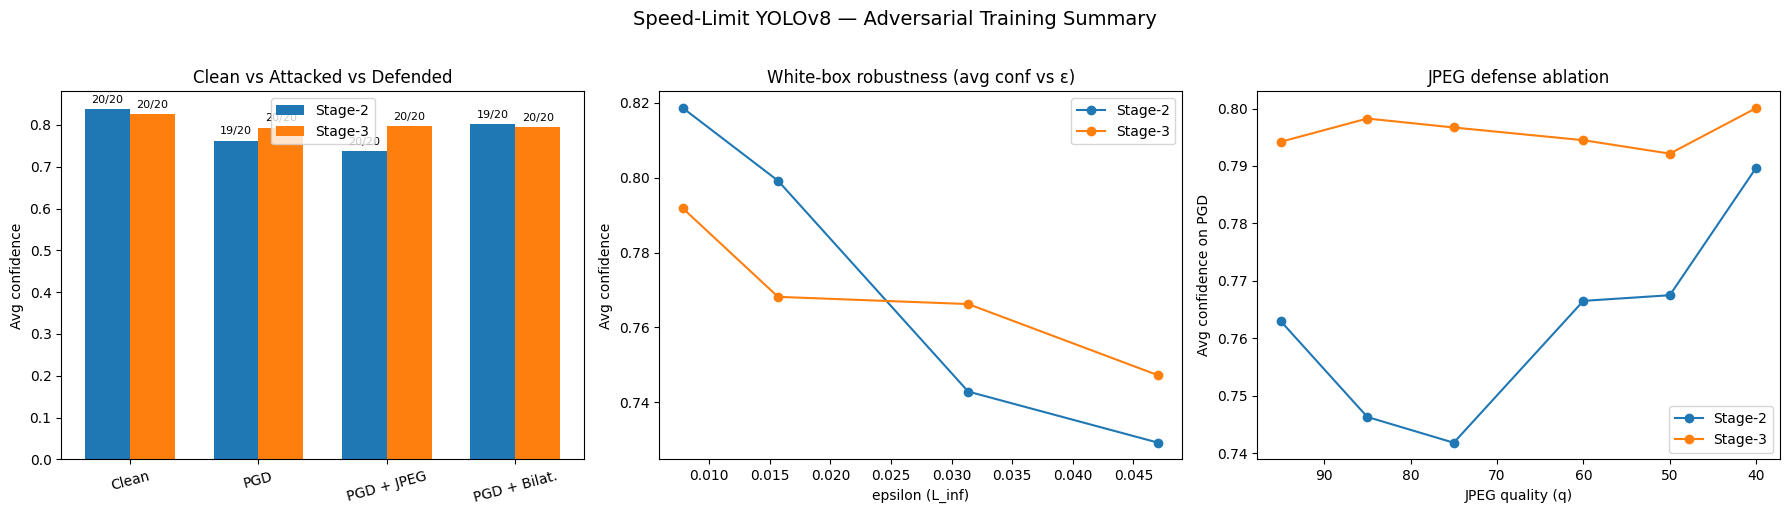

Saved summary to: /content/drive/MyDrive/CAPSTONE/final_summary.png


In [ ]:
# Final Cell — Summary figure: bars (clean/PGD/defenses) + ε-sweep + JPEG ablation
import os, csv, numpy as np
import matplotlib.pyplot as plt

SUMM_DIR = "/content/drive/MyDrive/CAPSTONE/eval_at_only/summaries"
OUT_PNG  = "/content/drive/MyDrive/CAPSTONE/final_summary.png"

def read_avg_conf_and_det(path):
    """Return (avg_conf, det_rate, total). CSV schema: image,model,score"""
    if not os.path.exists(path):
        return None, None, None
    scores = []
    total = 0
    with open(path, "r") as f:
        r = csv.DictReader(f)
        for row in r:

            if "score" not in row:
                continue
            total += 1
            s = row["score"]
            if s not in (None, "", "None"):
                try:
                    scores.append(float(s))
                except:
                    pass
    det_rate = len(scores)
    avg_conf = float(np.mean(scores)) if scores else None
    return avg_conf, det_rate, total

# --- 1) Bar chart data: clean, PGD, PGD+JPEG, PGD+Bilateral ---
files = {
    "Clean":        ("clean_stage2.csv",        "clean_stage3.csv"),
    "PGD":          ("pgd_stage2.csv",          "pgd_stage3.csv"),
    "PGD + JPEG":   ("pgd_jpeg_stage2.csv",     "pgd_jpeg_stage3.csv"),
    "PGD + Bilat.": ("pgd_bilateral_stage2.csv","pgd_bilateral_stage3.csv"),
}

bar_labels = []
stage2_means, stage3_means = [], []
stage2_det_text, stage3_det_text = [], []

for k,(f2,f3) in files.items():
    a2, d2, t2 = read_avg_conf_and_det(os.path.join(SUMM_DIR, f2))
    a3, d3, t3 = read_avg_conf_and_det(os.path.join(SUMM_DIR, f3))
    bar_labels.append(k)
    stage2_means.append(a2 if a2 is not None else 0.0)
    stage3_means.append(a3 if a3 is not None else 0.0)
    stage2_det_text.append(f"{d2}/{t2}" if d2 is not None else "—")
    stage3_det_text.append(f"{d3}/{t3}" if d3 is not None else "—")

# --- 2) ε-sweep line data ---
eps_path = os.path.join(SUMM_DIR, "eps_sweep_whitebox.csv")
eps_vals_s2, eps_avg_s2 = [], []
eps_vals_s3, eps_avg_s3 = [], []
if os.path.exists(eps_path):
    with open(eps_path, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            try:
                e = float(row["epsilon"])
                m = row["model"]
                a = row["avg_conf_whitebox"]
                a = float(a) if a not in (None,"","None") else None
            except Exception:
                continue
            if a is None:
                continue
            if m == "stage2":
                eps_vals_s2.append(e); eps_avg_s2.append(a)
            elif m == "stage3":
                eps_vals_s3.append(e); eps_avg_s3.append(a)
    # sort by epsilon
    order2 = np.argsort(eps_vals_s2); order3 = np.argsort(eps_vals_s3)
    eps_vals_s2 = list(np.array(eps_vals_s2)[order2])
    eps_avg_s2  = list(np.array(eps_avg_s2)[order2])
    eps_vals_s3 = list(np.array(eps_vals_s3)[order3])
    eps_avg_s3  = list(np.array(eps_avg_s3)[order3])

# --- 3) JPEG ablation line data ---
jpeg_path = os.path.join(SUMM_DIR, "jpeg_ablation.csv")
jpeg_q_s2, jpeg_avg_s2 = [], []
jpeg_q_s3, jpeg_avg_s3 = [], []
if os.path.exists(jpeg_path):
    with open(jpeg_path, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            try:
                q   = int(float(row["jpeg_quality"]))
                m   = row["model"]
                avg = row["avg_conf_on_pgd"]
                avg = float(avg) if avg not in (None,"","None") else None
            except Exception:
                continue
            if avg is None:
                continue
            if m == "stage2":
                jpeg_q_s2.append(q); jpeg_avg_s2.append(avg)
            elif m == "stage3":
                jpeg_q_s3.append(q); jpeg_avg_s3.append(avg)
    # sort by quality
    o2 = np.argsort(jpeg_q_s2); o3 = np.argsort(jpeg_q_s3)
    jpeg_q_s2   = list(np.array(jpeg_q_s2)[o2]); jpeg_avg_s2 = list(np.array(jpeg_avg_s2)[o2])
    jpeg_q_s3   = list(np.array(jpeg_q_s3)[o3]); jpeg_avg_s3 = list(np.array(jpeg_avg_s3)[o3])

# --- Plot: single figure with 3 panels ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: grouped bars
x = np.arange(len(bar_labels))
w = 0.35
axes[0].bar(x - w/2, stage2_means, width=w, label="Stage-2")
axes[0].bar(x + w/2, stage3_means, width=w, label="Stage-3")
axes[0].set_xticks(x)
axes[0].set_xticklabels(bar_labels, rotation=15)
axes[0].set_ylabel("Avg confidence")
axes[0].set_title("Clean vs Attacked vs Defended")
axes[0].legend()
# annotate det-rate on bars
for xi, v, txt in zip(x - w/2, stage2_means, stage2_det_text):
    axes[0].text(xi, v + 0.01, txt, ha="center", va="bottom", fontsize=8)
for xi, v, txt in zip(x + w/2, stage3_means, stage3_det_text):
    axes[0].text(xi, v + 0.01, txt, ha="center", va="bottom", fontsize=8)

# Panel B: epsilon sweep
if eps_vals_s2 and eps_vals_s3:
    axes[1].plot(eps_vals_s2, eps_avg_s2, marker="o", label="Stage-2")
    axes[1].plot(eps_vals_s3, eps_avg_s3, marker="o", label="Stage-3")
    axes[1].set_xlabel("epsilon (L_inf)")
    axes[1].set_ylabel("Avg confidence")
    axes[1].set_title("White-box robustness (avg conf vs ε)")
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, "eps_sweep_whitebox.csv not found", ha="center", va="center")
    axes[1].axis("off")

# Panel C: JPEG ablation
if jpeg_q_s2 and jpeg_q_s3:
    axes[2].plot(jpeg_q_s2, jpeg_avg_s2, marker="o", label="Stage-2")
    axes[2].plot(jpeg_q_s3, jpeg_avg_s3, marker="o", label="Stage-3")
    axes[2].set_xlabel("JPEG quality (q)")
    axes[2].set_ylabel("Avg confidence on PGD")
    axes[2].set_title("JPEG defense ablation")
    axes[2].invert_xaxis()
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, "jpeg_ablation.csv not found", ha="center", va="center")
    axes[2].axis("off")

fig.suptitle("Speed-Limit YOLOv8 — Adversarial Training Summary", y=1.02, fontsize=14)
fig.tight_layout()
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()
print("Saved summary to:", OUT_PNG)


**Figure:** Summary of adversarial robustness for speed-limit YOLOv8.  
Left: On clean images both models detect all signs; under PGD (ε=8/255) the AT model improves detection (20/20) and confidence; JPEG defense further boosts robustness.  
Middle: White-box ε-sweep shows a crossover—AT overtakes the baseline at ε≥8/255.  
Right: JPEG ablation on PGD—best range is q≈75–85; after JPEG-aware fine-tunes, the AT model also exceeds the baseline at harsh qualities (q≤60).
